Import stuff
------------

In [1]:
import os
import sys

import numpy as np

import tensorflow as tf
from tensorflow import keras

# Change this with the directory where you cloned the imgdetect-utils repo
basedir = os.path.join(os.path.expanduser('~'), 'Downloads/uv_cleaner/human_detection')
sys.path.append(os.path.join(basedir))
sys.path.append(os.path.join(basedir, 'imgdetect-utils'))

from src.image_helpers import plot_images_grid, create_dataset_files
from src.train_helpers import load_data, plot_results, export_model

# The Tensorflow model and properties file will be stored here
tf_model_dir = os.path.join(basedir, 'models', 'tensorflow')
tf_model_file = os.path.join(tf_model_dir, 'saved_model.pb')
tf_properties_file = os.path.join(tf_model_dir, 'saved_model.json')

# Base directory that contains your training images and dataset files
dataset_base_dir = os.path.join(basedir, 'datasets')
dataset_dir = os.path.join(dataset_base_dir, 'data')

# Store your thermal camera images here
img_dir = os.path.join(dataset_base_dir, 'images')

# Size of the input images
input_size = (24, 32)

Create model directories
------------------------

In [2]:
os.makedirs(tf_model_dir, mode=0o775, exist_ok=True)

Create a dataset files from the available images
------------------------------------------------

In [3]:
dataset_files = create_dataset_files(img_dir, dataset_dir,
                                     split_size=500,
                                     num_threads=1,
                                     resize=input_size,
                                     color_convert='COLOR_BGR2RGB')
dataset_files

Processing 2085 images to 5 dataset files. Format: /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset{:01}.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset0.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset1.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset2.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset3.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset4.npz


['/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset0.npz',
 '/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset1.npz',
 '/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset2.npz',
 '/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset3.npz',
 '/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset4.npz']

Get the training and test set randomly out of the dataset with a split of 70/30
-------------------------------------------------------------------------------

In [4]:
train_set, test_set, classes = load_data(*dataset_files, split_percentage=0.8)
print('Loaded {} training images and {} test images. Classes: {}'.format(
    train_set.shape[0], test_set.shape[0], classes))

Loaded 1668 training images and 417 test images. Classes: ['negative' 'positive']


/Users/hyungjaekim/opt/anaconda3/envs/uv_cleaner/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [5]:
train_images = np.asarray([item[0] for item in train_set])
train_labels = np.asarray([item[1] for item in train_set])
test_images = np.asarray([item[0] for item in test_set])
test_labels = np.asarray([item[1] for item in test_set])

Inspect the first 25 images in the training set
-----------------------------------------------


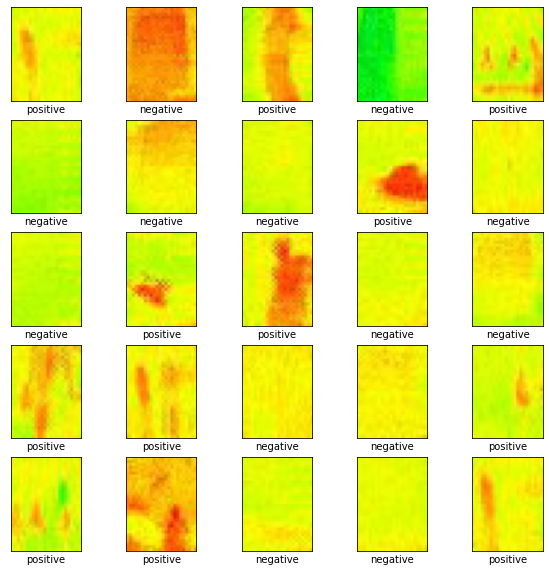

In [6]:
plot_images_grid(images=train_images, labels=train_labels, classes=classes, rows=5, cols=5)


Declare the model
-----------------

* Flatten input
* Layer 1: 60% the number of pixels per image
* Layer 2: 30% the number of pixels per image
* Layer 3: as many neurons as the output labels (in this case 2: negative, positive)

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images[0].shape),
    keras.layers.Dense(int(0.6 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(int(0.3 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(len(classes), activation=tf.nn.softmax)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Compile the model
-----------------

- *Loss function*:This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
- *Optimizer*: This is how the model is updated based on the data it sees and its loss function.
- *Metrics*: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train the model
---------------

In [9]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

val_images = train_images[:1000]
partial_images = train_images[1000:]
val_labels = train_labels[:1000]
partial_labels = train_labels[1000:]

history = model.fit(partial_images, partial_labels, epochs = 100, 
                    validation_data=(val_images, val_labels), callbacks=[earlystopping])

#model.fit(train_images, train_labels, epochs=100)

Train on 668 samples, validate on 1000 samples
Epoch 1/100
 32/668 [>.............................] - ETA: 1s - loss: 0.6402 - acc: 0.6562

2021-08-09 00:13:16.303177: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-09 00:13:16.314830: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe27a5acd40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-09 00:13:16.314842: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


668/668 [==============================] - 0s 429us/sample - loss: 1.1107 - acc: 0.5584 - val_loss: 0.5687 - val_acc: 0.7790
Epoch 2/100
668/668 [==============================] - 0s 265us/sample - loss: 0.5243 - acc: 0.7305 - val_loss: 0.5039 - val_acc: 0.7330
Epoch 3/100
668/668 [==============================] - 0s 265us/sample - loss: 0.4647 - acc: 0.7650 - val_loss: 0.3533 - val_acc: 0.8640
Epoch 4/100
668/668 [==============================] - 0s 251us/sample - loss: 0.3548 - acc: 0.8398 - val_loss: 0.2923 - val_acc: 0.8880
Epoch 5/100
668/668 [==============================] - 0s 247us/sample - loss: 0.3211 - acc: 0.8653 - val_loss: 0.2692 - val_acc: 0.8770
Epoch 6/100
668/668 [==============================] - 0s 252us/sample - loss: 0.3585 - acc: 0.8398 - val_loss: 0.2596 - val_acc: 0.9080
Epoch 7/100
668/668 [==============================] - 0s 242us/sample - loss: 0.2911 - acc: 0.8772 - val_loss: 0.2191 - val_acc: 0.8960
Epoch 8/100
668/668 [==============================] 

668/668 [==============================] - 0s 234us/sample - loss: 0.2053 - acc: 0.9311 - val_loss: 0.3456 - val_acc: 0.8780
Epoch 61/100
668/668 [==============================] - 0s 226us/sample - loss: 0.1099 - acc: 0.9536 - val_loss: 0.1601 - val_acc: 0.9400
Epoch 62/100
668/668 [==============================] - 0s 261us/sample - loss: 0.0840 - acc: 0.9686 - val_loss: 0.0693 - val_acc: 0.9770


Evaluate accuracy against the test set
--------------------------------------

In [10]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

417/417 [==============================] - 0s 79us/sample - loss: 0.3592 - acc: 0.9592
Test accuracy: 0.9592326


Make predictions on the test set
--------------------------------

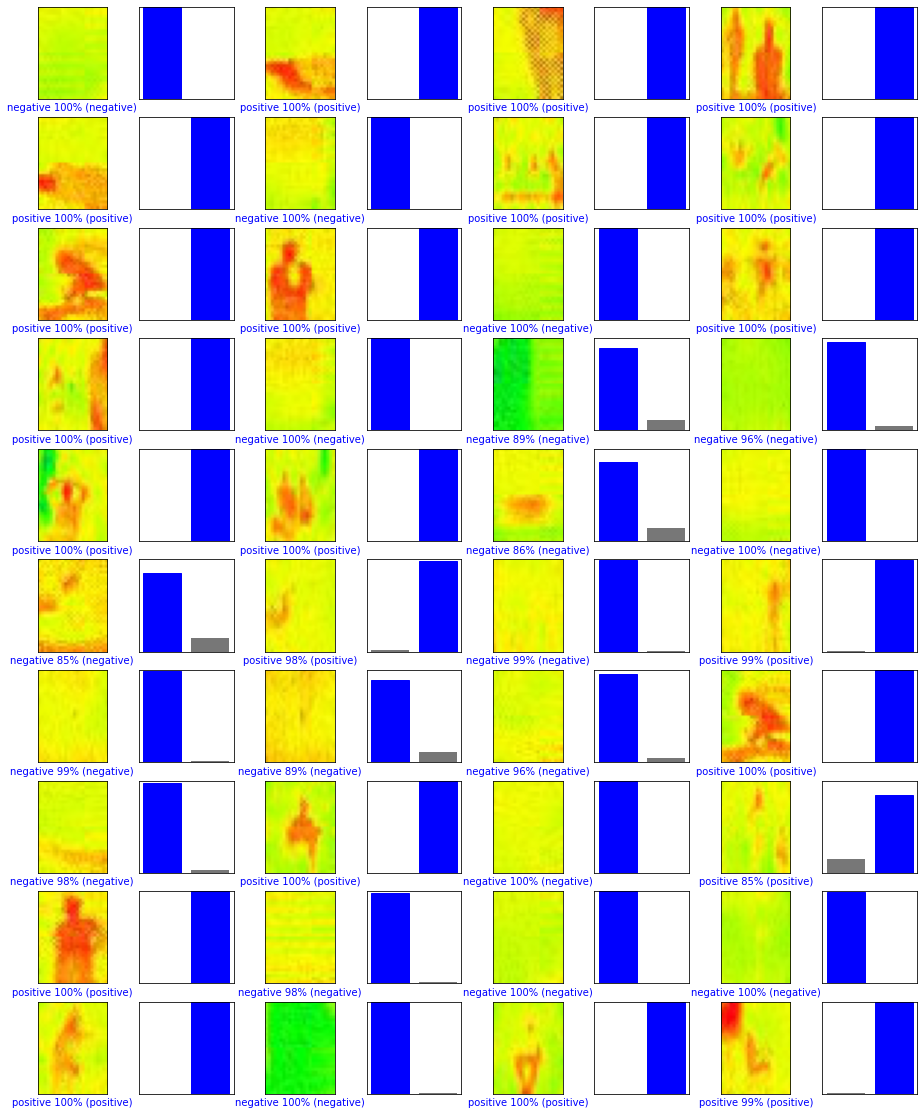

In [11]:
predictions = model.predict(test_images)
plot_results(images=test_images, labels=test_labels, classes=classes, predictions=predictions, rows=10, cols=4)

Export as a Tensorflow model
----------------------------

In [12]:
export_model(model, tf_model_file,
             properties_file=tf_properties_file,
             classes=classes,
             input_size=input_size)



Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 23 variables.
INFO:tensorflow:Converted 23 variables to const ops.

